Please upload the 'Electric_Production.csv' file:


Saving Electric_Production.csv to Electric_Production.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - loss: 0.0904 - val_loss: 0.0319
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0226 - val_loss: 0.0409
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0168 - val_loss: 0.0176
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0151 - val_loss: 0.0234
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0142 - val_loss: 0.0177
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0128 - val_loss: 0.0187
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0123 - val_loss: 0.0178
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0129 - val_loss: 0.0210
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0148 - val_loss: 0.0191
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0128 - val_loss: 0.0176
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0123 - val_loss: 0.0175
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0

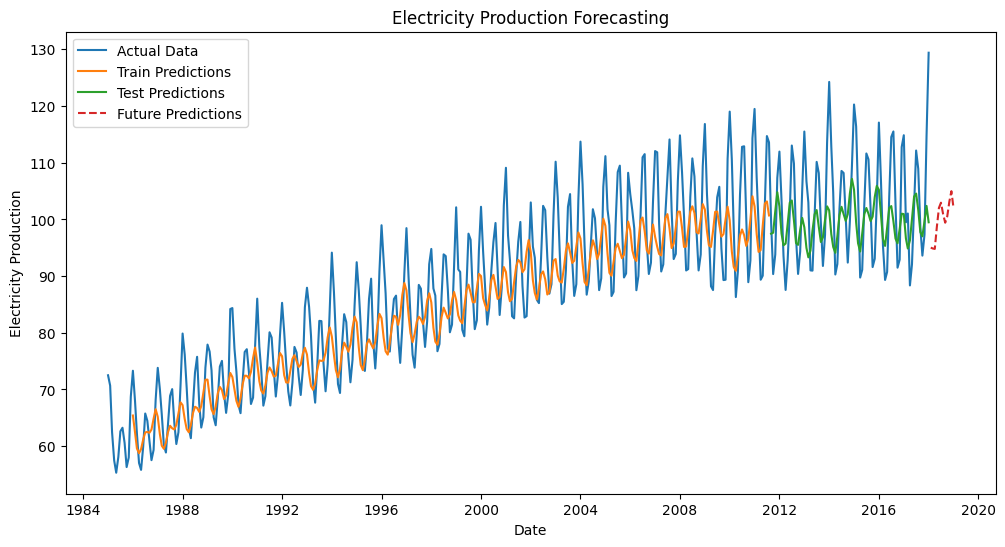

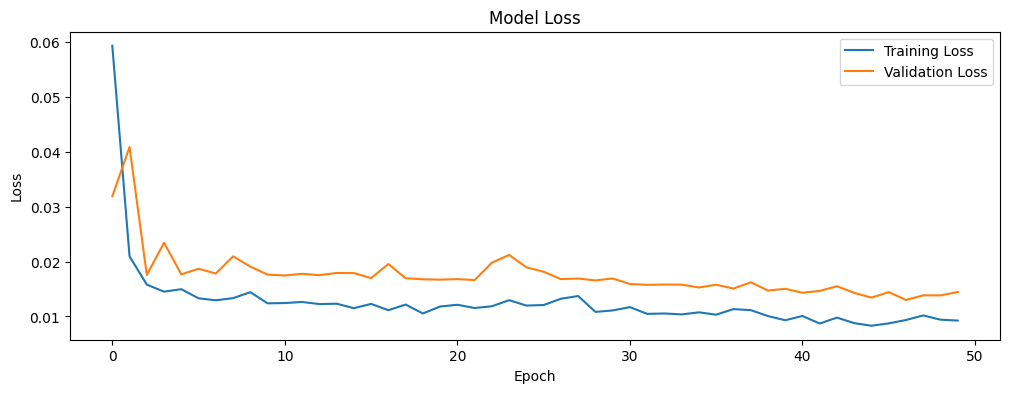

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import files  # Colab-specific library for file upload

# Step 1: Upload the CSV file
print("Please upload the 'Electric_Production.csv' file:")
uploaded = files.upload()

# Load the CSV file
# Assuming the uploaded file is named 'Electric_Production.csv'
df = pd.read_csv(list(uploaded.keys())[0])

# Ensure the DATE column is parsed as datetime and set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['IPG2211A2N'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 12  # Use 12 months to predict the next month
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 2: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 4: Evaluate the Model
# Predict on test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Step 5: Forecast Future Values
# Use the last sequence from the data to predict the next 12 months
last_sequence = scaled_data[-sequence_length:]
future_predictions = []
for _ in range(12):
    last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
    next_pred = model.predict(last_sequence_reshaped, verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

# Step 6: Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IPG2211A2N'], label='Actual Data')
plt.plot(df.index[sequence_length:train_size + sequence_length], train_predict, label='Train Predictions')
plt.plot(df.index[train_size + sequence_length:], test_predict, label='Test Predictions')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
plt.title('Electricity Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()